## New York City Taxi Fare Price Prediction Using Python Techniques!
#### Introduction: The New York City Taxi Fare dataset was obtained from Kaggle.com. It has over 55M rows and 8 columns. It came with accompanying datasets: the test.csv and sample_submission datasets.
#### In this exploratory analysis, because of the local mechine I shall be using about 1% of the dataset. Assumming I have GPU and cuda, cudf I should be able to analysis the entire 55M rows. Essentially, the columns were examined, we checked whether the datasets are categorical or continuous. Then we examined the extent of missing values and performed data wrangling by converting the datetime to its components and determined distance from the pickup and dropoff longitudes and latitudes. 

In [1]:
#import some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from datetime import datetime, tzinfo
from dateutil import tz
import pytz
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb

In [2]:
# Loading the datasets
df_train = pd.read_csv(r"C:\Users\owner\Desktop\new-york-city-taxi-fare-prediction\train.csv", nrows = 550000).iloc[:, 1:]
df_test = pd.read_csv(r"C:\Users\owner\Desktop\new-york-city-taxi-fare-prediction\test.csv")
df_sample_submission = pd.read_csv(r"C:\Users\owner\Desktop\WM2\sample_submission.csv")

In [3]:
df_sample_submission.columns

Index(['key', 'fare_amount'], dtype='object')

In [4]:
df_train.columns, df_test.columns

(Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
       dtype='object'),
 Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
       dtype='object'))

### we check the distribution of the target parameters as shown below.

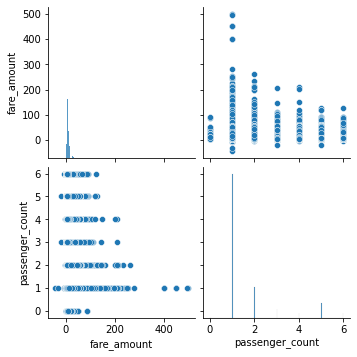

In [5]:
sns.pairplot(df_train[['fare_amount', 'passenger_count']])

### 2.  Data Cleaning extraction and Manipulation. Lets clean the dataset by removing, filling and replacing missing values and as well as drop columns.

In [6]:
df_train.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    6
dropoff_latitude     6
passenger_count      0
dtype: int64

In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#apply it to features

imputer.fit(df_train[['dropoff_longitude','dropoff_latitude']])
df_train[['dropoff_longitude','dropoff_latitude']] = imputer.transform(df_train[['dropoff_longitude','dropoff_latitude']])

In [8]:
df_train.shape, df_test.shape

((550000, 7), (9914, 7))

### Feature Engineering and Transformation

In [9]:
df_train['fare_amount'] = pd.to_numeric(df_train['fare_amount'], errors = 'coerce')

In [10]:
#Transforming the datetime into Year, month, day, date, hour and minute
df_train['pickup_datetime']= pd.to_datetime(df_train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

#CONVERT TO HOUR, DATE, DAY, MONTH, YEAR
df_train['Hour'] = df_train['pickup_datetime'].dt.hour
df_train['minute'] = df_train['pickup_datetime'].dt.minute
df_train['date'] = df_train['pickup_datetime'].dt.day
df_train['day'] = df_train['pickup_datetime'].dt.dayofweek
df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['year'] = df_train['pickup_datetime'].dt.year

In [11]:
df_train.drop('pickup_datetime', axis = 1, inplace = True)

In [12]:
df_train.head(4)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,minute,date,day,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,26,15,0,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,52,5,1,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,35,18,3,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,30,21,5,4,2012


In [13]:
#The same transformation is performed on the test dataset
df_test['pickup_datetime']= pd.to_datetime(df_test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

#CONVERT TO HOUR, DATE, DAY, MONTH, YEAR
df_test['Hour'] = df_test['pickup_datetime'].dt.hour
df_test['minute'] = df_test['pickup_datetime'].dt.minute
df_test['date'] = df_test['pickup_datetime'].dt.day
df_test['day'] = df_test['pickup_datetime'].dt.dayofweek
df_test['month'] = df_test['pickup_datetime'].dt.month
df_test['year'] = df_test['pickup_datetime'].dt.year

In [14]:
df_test.drop('pickup_datetime', axis = 1, inplace = True), df_test.head(4)

(None,
                            key  pickup_longitude  pickup_latitude  \
 0  2015-01-27 13:08:24.0000002        -73.973320        40.763805   
 1  2015-01-27 13:08:24.0000003        -73.986862        40.719383   
 2  2011-10-08 11:53:44.0000002        -73.982524        40.751260   
 3  2012-12-01 21:12:12.0000002        -73.981160        40.767807   
 
    dropoff_longitude  dropoff_latitude  passenger_count  Hour  minute  date  \
 0         -73.981430         40.743835                1    13       8    27   
 1         -73.998886         40.739201                1    13       8    27   
 2         -73.979654         40.746139                1    11      53     8   
 3         -73.990448         40.751635                1    21      12     1   
 
    day  month  year  
 0    1      1  2015  
 1    1      1  2015  
 2    5     10  2011  
 3    5     12  2012  )

In [15]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,minute,date,day,month,year
count,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000
mean,11.348953,-72.527701,39.922421,-72.523546,39.917505,1.683707,13.509662,29.556084,15.690642,3.041538,6.268595,2011.739024
std,9.883326,12.545991,7.950921,11.694875,7.298630,1.307607,6.511634,17.333053,8.684871,1.949368,3.437547,1.860693
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-2559.748913,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2009.000000
25%,6.000000,-73.992043,40.734942,-73.991390,40.734058,1.000000,9.000000,15.000000,8.000000,1.000000,3.000000,2010.000000
50%,8.500000,-73.981790,40.752681,-73.980141,40.753135,1.000000,14.000000,30.000000,16.000000,3.000000,6.000000,2012.000000
75%,12.500000,-73.967108,40.767092,-73.963601,40.768123,2.000000,19.000000,45.000000,23.000000,5.000000,9.000000,2013.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000,23.000000,59.000000,31.000000,6.000000,12.000000,2015.000000


In [16]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,minute,date,day,month,year
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,13.467420,29.548416,16.194170,2.852834,6.857979,2011.815816
std,0.042774,0.033541,0.039072,0.035435,1.278747,6.868584,18.674818,8.838482,1.994451,3.353272,1.803347
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2009.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,8.000000,13.000000,9.000000,1.000000,4.000000,2010.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,15.000000,33.000000,16.000000,3.000000,7.000000,2012.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,19.000000,45.000000,25.000000,5.000000,10.000000,2014.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,23.000000,59.000000,31.000000,6.000000,12.000000,2015.000000


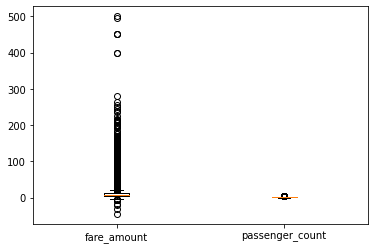

In [17]:
fig, ax = plt.subplots()
ax.boxplot([df_train['fare_amount'],
           df_train['passenger_count']])
ax.set_xticklabels(["fare_amount", "passenger_count"])
plt.show()

### Based on the stat summaries we shall use the following features' ranges and we can the trim the outliers.
#### Removing outliers on passenger_count, fare_amount, pickup latitude, longitude
#### . fare_amount: 1 to 500
#### . longitudes: -75 to -72
#### - latitudes: 40 to 42
#### - passenger_count: 1 to 6

In [18]:
def remove_outliers(df_train):
    return df_train[(df_train['fare_amount'] > -1) &
           (df_train['fare_amount'] <= 500) &
           (df_train['pickup_longitude'] >= -75) &
           (df_train['pickup_longitude'] <= -72) &
           (df_train['dropoff_longitude'] >= -75) &
           (df_train['dropoff_longitude'] <= -72) &
           (df_train['pickup_latitude'] >= 40) &
           (df_train['pickup_latitude'] <= 42) &
           (df_train['dropoff_latitude'] >= 40) &
           (df_train['dropoff_latitude'] <= 42) &
           (df_train['passenger_count'] >= 1) &
           (df_train['passenger_count'] <= 6)]             

In [19]:
df_train = remove_outliers(df_train)

In [20]:
df_train.shape, df_train.isnull().sum()

((536593, 12),
 fare_amount          0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    0
 dropoff_latitude     0
 passenger_count      0
 Hour                 0
 minute               0
 date                 0
 day                  0
 month                0
 year                 0
 dtype: int64)

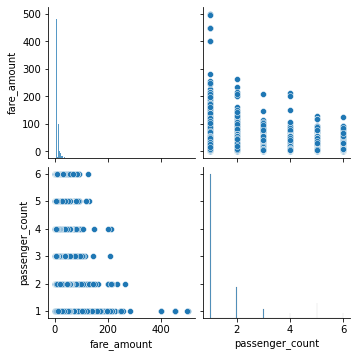

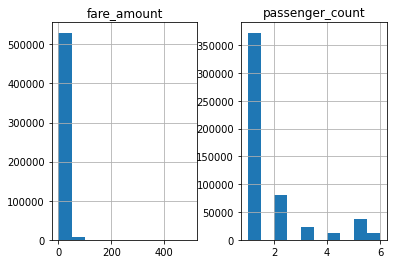

In [21]:
sns.pairplot(df_train[['fare_amount', 'passenger_count']]), df_train[['fare_amount', 'passenger_count']].hist()
plt.show()

In [22]:
from math import *

def haversine(a):
    lon1=a[0]
    lat1=a[1]
    lon2=a[2]
    lat2=a[3]
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c =  2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [23]:
df_train['distance'] = df_train[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)

In [24]:
df_test['distance'] = df_test[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)

In [25]:
df_train.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1, inplace=True)

In [26]:
df_test.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1, inplace=True)

In [27]:
df_train['Hour'] = df_train['Hour'].astype('int64')
df_train['minute'] = df_train['minute'].astype('int64')
df_train['date'] = df_train['date'].astype('int64')
df_train['day'] = df_train['day'].astype('int64')
df_train['month'] = df_train['month'].astype('int64')
df_train['year'] = df_train['year'].astype('int64')

In [28]:
df_test['Hour'] = df_test['Hour'].astype('int64')
df_test['minute'] = df_test['minute'].astype('int64')
df_test['date'] = df_test['date'].astype('int64')
df_test['day'] = df_test['day'].astype('int64')
df_test['month'] = df_test['month'].astype('int64')
df_test['year'] = df_test['year'].astype('int64')

In [29]:
df_train['tot_minute'] = df_train['Hour']*60 + df_train['minute']
df_test['tot_minute'] = df_test['Hour']*60 + df_test['minute']

In [30]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536593 entries, 0 to 549999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fare_amount      536593 non-null  float64
 1   passenger_count  536593 non-null  int64  
 2   Hour             536593 non-null  int64  
 3   minute           536593 non-null  int64  
 4   date             536593 non-null  int64  
 5   day              536593 non-null  int64  
 6   month            536593 non-null  int64  
 7   year             536593 non-null  int64  
 8   distance         536593 non-null  float64
 9   tot_minute       536593 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 45.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              9914 non-null   object 
 1   passenger_count  9914 no

(None, None)

In [31]:
df_train.describe()

,fare_amount,passenger_count,Hour,minute,date,day,month,year,distance,tot_minute
count,536593.000000,536593.000000,536593.000000,536593.000000,536593.000000,536593.000000,536593.000000,536593.000000,536593.000000,536593.000000
mean,11.341097,1.690303,13.510810,29.559881,15.684962,3.041456,6.272024,2011.737662,3.333248,840.208473
std,9.820420,1.306266,6.508663,17.332991,8.684384,1.949068,3.438817,1.866080,3.782786,390.857670
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2009.000000,0.000000,0.000000
25%,6.000000,1.000000,9.000000,15.000000,8.000000,1.000000,3.000000,2010.000000,1.254924,565.000000
50%,8.500000,1.000000,14.000000,30.000000,16.000000,3.000000,6.000000,2012.000000,2.153375,879.000000
75%,12.500000,2.000000,19.000000,45.000000,23.000000,5.000000,9.000000,2013.000000,3.923146,1172.000000
max,500.000000,6.000000,23.000000,59.000000,31.000000,6.000000,12.000000,2015.000000,140.514983,1439.000000


In [32]:
df_test.describe()

,passenger_count,Hour,minute,date,day,month,year,distance,tot_minute
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,1.671273,13.467420,29.548416,16.194170,2.852834,6.857979,2011.815816,3.435371,837.593605
std,1.278747,6.868584,18.674818,8.838482,1.994451,3.353272,1.803347,3.972374,411.308764
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2009.000000,0.000000,0.000000
25%,1.000000,8.000000,13.000000,9.000000,1.000000,4.000000,2010.000000,1.298277,512.000000
50%,1.000000,15.000000,33.000000,16.000000,3.000000,7.000000,2012.000000,2.217412,902.000000
75%,2.000000,19.000000,45.000000,25.000000,5.000000,10.000000,2014.000000,4.045302,1191.000000
max,6.000000,23.000000,59.000000,31.000000,6.000000,12.000000,2015.000000,99.996040,1438.000000


### Next we set the dataset for Training and Validation for LightGBM and XGBOOST

In [33]:
X = df_train.drop('fare_amount', axis = 1)
y = df_train.fare_amount

# Splitting the test & train dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 123)

#imputing missing values in the target
y.fillna(y.mean(), inplace = True)

In [34]:
#Applying Gradient Boosting alias XGB
dtrain = xgb.DMatrix(data = X, label = y)
dtest = xgb.DMatrix(X_test)

In [35]:
#SET PARAMETERS FOR THE XGBOOST
from datetime import datetime
begin = datetime.now()
xg = xgb.XGBRegressor(objective = 'reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                     max_depth = 5, alpha = 10, n_estimators = 10)
# fitting the regressor
xg.fit(X_train, y_train)
end = datetime.now()

#Time execution of the model
execution_time_xgb = begin - end
execution_time_xgb
#Performing Prediction of the model on test set
ypred = xg.predict(X_test)
ypred[: 8]

predictionX = [round(value, 2) for value in ypred]
predictionX[: 12]

[18:15:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


[7.27, 6.94, 7.16, 7.73, 7.6, 6.9, 6.92, 6.71, 7.25, 8.71, 6.15, 6.33]

In [36]:
#LETS CONVERT PROBABILITIES INTO 1 OR 0 USING FOR LOOP
for i in range(0, 9913):
    if ypred[i] >= 0.5:
        ypred[i] = 1
    else:
        ypred[i] = 0
print(ypred[i])

1.0


In [37]:
#Next WE DETERMINE THE ACCURACY OF OUR MODEL USING RMSE BY INVOKING MEAN_SQUARED_ERROR
rmse = np.sqrt(mean_squared_error(y_test, predictionX))
print('RMSE: %f' % (rmse))

RMSE: 9.145609


### This rmse is high, we can deploy KFOLD Validation upon XGB
### Create Hyper- parameter params

In [38]:
params = {"objective": "reg:linear", 'colsample_bytree': 0.3,
         'learning_rate': 0.1, 'max_depth': 6, 'alpha': 10}
cv_results = xgb.cv(dtrain = dtrain, params = params, 
                   nfold = 12, num_boost_round = 100, early_stopping_rounds = 10,
                   metrics = 'rmse', as_pandas = True, seed = 123)
cv_results.head()

#Extract and print final boosting round metric
print(cv_results["test-rmse-mean"].tail(1))

[18:15:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:18

In [39]:
prediction_df = pd.concat([X_test, y_test], axis = 1)
prediction_df['predicted'] = predictionX
prediction_df.head(8).iloc[:,9:]

,fare_amount,predicted
514526,7.50,7.27
484588,11.30,6.94
122251,16.67,7.16
58979,8.50,7.73
485727,10.50,7.60
266999,5.00,6.90
350837,5.00,6.92
405998,6.50,6.71


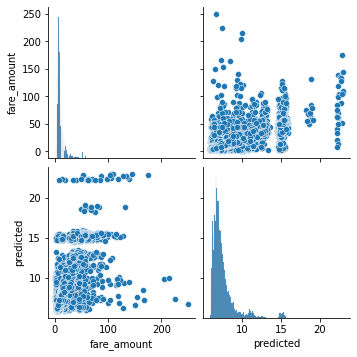

In [40]:
sns.pairplot(prediction_df[['fare_amount', 'predicted']])

## Attempting to present a representation of the predictions

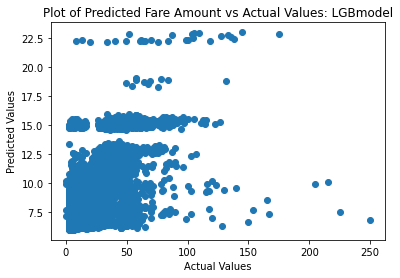

In [41]:
plt.scatter(y_test, predictionX)
plt.title("Plot of Predicted Fare Amount vs Actual Values: LGBmodel")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## Next we consider another model to see whether we can get a better predictions for the fare_amount. We are going to use the LGBM

C:\Users\owner\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\owner\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

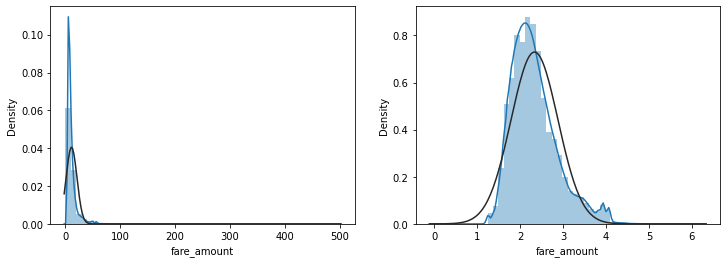

In [42]:
# The distributionof the fare_amount as the target variable and its modification
#pd.options.display.max_columns = None

fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(df_train['fare_amount'], ax = ax[0], fit = norm)
sns.distplot(np.log(df_train[('fare_amount')] + 1), ax = ax[1], fit = norm)

In [43]:
from sklearn.metrics import mean_squared_log_error
hyper_params = {'task':'train', 'boosting_type': 'gbdt',
                   'objective':'regression',
                   'metric':['l1', 'l2'],
                   'learning_rate': 0.005,
                   'feature_fraction': 0.9, 'bagging_fraction':0.7,
                   'bagging_freq':10, 'verbose': 0,
                   'max_depth': 8, 'num_leaves': 128,
                   'max_bin': 512, 'num_iterations': 100000}
lgbm = lgb.LGBMRegressor(**hyper_params)
lgbm.fit(X_train, y_train, eval_set = [(X_test, y_test)],
        eval_metric = 'l1', early_stopping_rounds = 1000)
#Next is to determine the prediction
y_pred = lgbm.predict(X_train, num_iteration = lgbm.best_iteration_)

#We calculate the Root Mean Squaree Error
print('RMSE OF PREDICTION Is:', round(mean_squared_log_error(y_pred, y_train)**0.5, 5))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM

In [44]:
print(y_pred[:10])

[ 7.45569997  4.94296138  9.08983233 23.75237962  6.8774221   4.47552285
  7.85863348  5.49422557  7.8190572   7.19652116]


In [45]:
prediction = [round(value, 2) for value in y_pred]
prediction[: 10]

[7.46, 4.94, 9.09, 23.75, 6.88, 4.48, 7.86, 5.49, 7.82, 7.2]

In [46]:
prediction_df = pd.concat([y_train], axis = 1)
prediction_df['predicted'] = prediction
#prediction_df.head().iloc[:,9:]
prediction_df.head()

,fare_amount,predicted
177129,5.7,7.46
493971,4.5,4.94
376549,8.5,9.09
548797,29.3,23.75
30528,7.3,6.88


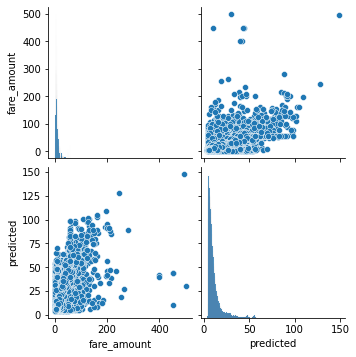

In [47]:
#A pair plot to show how the fare amount and predicted fare amount relate using lightgbm
sns.pairplot(prediction_df[['fare_amount', 'predicted']])

### we check the prediction of fare_amount using Ridge Regression and as well as Random Forest

In [48]:
#Ridge Regression
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
ridg = Ridge(alpha = 0.1, normalize = True)

In [49]:
#Wefit and predict after our instantiation of the Ridge Regression
ridg.fit(X_train, y_train)
rigpred = ridg.predict(X_test)
rigpred

array([ 6.6891097 ,  6.81665191,  5.24719661, ...,  6.84519763,
       10.60385677,  8.06987632])

In [50]:
#Accuracy of the model
from sklearn.metrics import accuracy_score
ridg.score(X_test, y_test)

0.6596001020130743

In [51]:
#the Errors and scores
score = ridg.score(X_train, y_train)
print("R-squared: ", score)

mse = mean_squared_error(y_test, rigpred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

R-squared:  0.6516780153544578
MSE:  33.42650463357086
RMSE:  16.71325231678543


In [52]:
rigprediction = [round(value, 2) for value in rigpred]
rigprediction[: 8]

[6.69, 6.82, 5.25, 9.64, 4.61, 11.17, 31.92, 8.07]

In [53]:
prediction2_df = pd.concat([X_test, y_test], axis = 1)
prediction2_df['predicted'] = rigprediction
prediction2_df.head(10).iloc[:,9:]

,fare_amount,predicted
2305,6.50,6.69
495,6.90,6.82
269755,2.90,5.25
506129,6.50,9.64
419225,4.90,4.61
54553,8.00,11.17
285845,54.54,31.92
228876,6.50,8.07
145497,4.50,6.17
489689,6.50,6.96


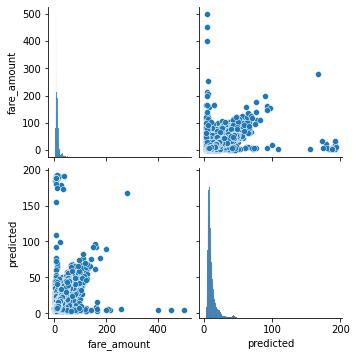

In [54]:
sns.pairplot(prediction2_df[['fare_amount', 'predicted']])

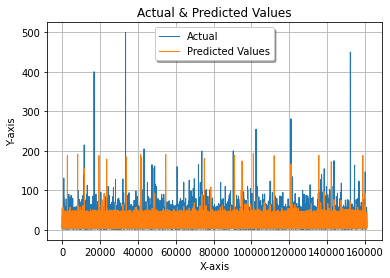

In [55]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth = 1, label = "Actual")
plt.plot(x_ax, rigprediction, linewidth = 1.1, label = "Predicted Values")
plt.title("Actual & Predicted Values")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend(loc = "best", fancybox = True, shadow = True)
plt.grid(True)
plt.show()

### Can RandomForest give better Predictions of the NYC Taxi Fare amount? What actual constitute a correct prediction? Distance and Time of ride are factors that constitute the actual fare amount to be charged.

array([[<AxesSubplot:title={'center':'fare_amount'}>,
        <AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'Hour'}>],
       [<AxesSubplot:title={'center':'minute'}>,
        <AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'distance'}>],
       [<AxesSubplot:title={'center':'tot_minute'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

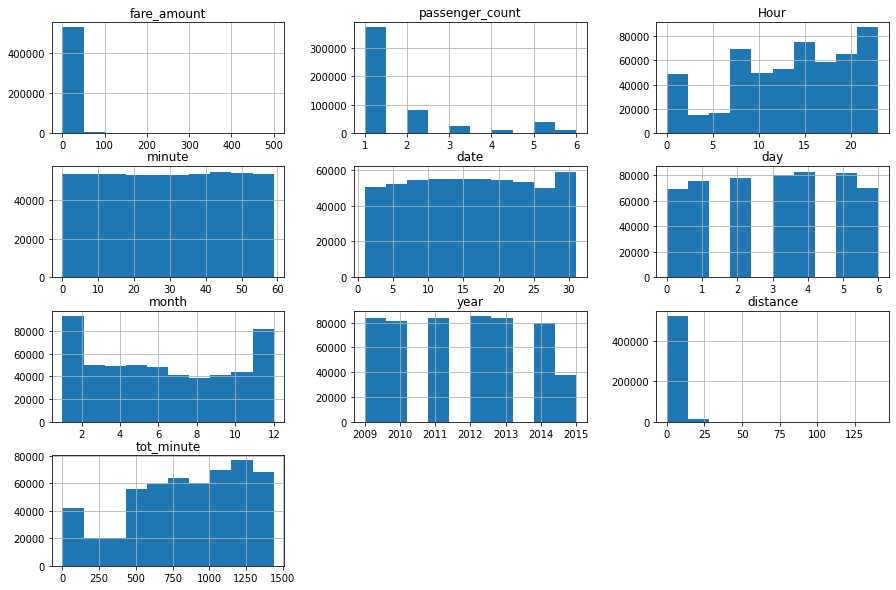

In [56]:
df_train.hist(figsize = (15,10))

<AxesSubplot:xlabel='distance', ylabel='fare_amount'>

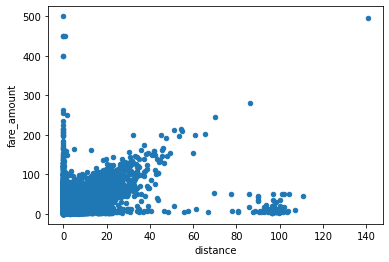

In [57]:
df_train.plot(x = 'distance', y = 'fare_amount', kind = 'scatter')

<AxesSubplot:>

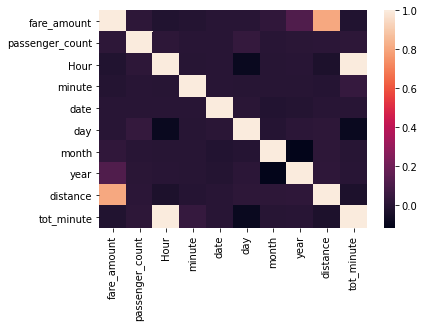

In [58]:
#Correlation between the variables in the df_train
corr = df_train.corr()
corr
sns.heatmap(corr)

In [59]:
# Instantiate the RandomForestRegressor
modelRFR = RandomForestRegressor()
modelRFR

RandomForestRegressor()

In [60]:
#Next is to fit and predict with the model on the train dataset
modelRFR.fit(X_train, y_train)

ypredrfr = modelRFR.predict(X_test)

In [61]:
ypredrfr

array([ 5.62  ,  5.776 ,  5.208 , ...,  5.636 , 10.4057,  7.65  ])

In [62]:
#Next is to determine the Accuracy of the modelRFR
score = modelRFR.score(X_test, y_test)
print("R-squared: ", score)

R-squared:  0.7439329871921156


In [63]:
#We determine the prediction values and how accurate using MSE and RMSE metric
rfrpredicted = [round(value, 2) for value in ypredrfr]
print(rfrpredicted[: 10])

[5.62, 5.78, 5.21, 8.26, 4.58, 12.42, 34.75, 6.96, 5.31, 4.8]


In [64]:
from sklearn.metrics import accuracy_score
mse = mean_squared_error(y_test, ypredrfr)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

MSE:  25.145204921466075
RMSE:  12.572602460733037


In [65]:
prediction_df = pd.concat([X_test, y_test], axis = 1)
prediction_df['predicted'] = rfrpredicted
prediction_df.head().iloc[:,9:]

,fare_amount,predicted
2305,6.5,5.62
495,6.9,5.78
269755,2.9,5.21
506129,6.5,8.26
419225,4.9,4.58


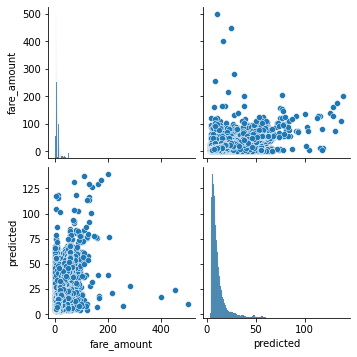

In [66]:
sns.pairplot(prediction_df[['fare_amount', 'predicted']])

<AxesSubplot:>

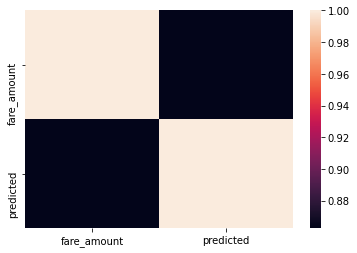

In [67]:
cor1 = prediction_df.iloc[:, 9:].corr()
sns.heatmap(cor1)

In [68]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_yhat = ols.predict(X_test)

In [69]:
ols_yhat

array([ 6.2317003 ,  6.37054629,  4.65615622, ...,  6.40855376,
       10.54225557,  7.73643062])

In [70]:
#X = sm.add.constant(X)
model = sm.OLS(y_train, X_train).fit()
summary = model.summary()
print(summary)

                                 OLS Regression Results                                
Dep. Variable:            fare_amount   R-squared (uncentered):                   0.849
Model:                            OLS   Adj. R-squared (uncentered):              0.849
Method:                 Least Squares   F-statistic:                          2.640e+05
Date:                Fri, 03 Dec 2021   Prob (F-statistic):                        0.00
Time:                        18:31:12   Log-Likelihood:                     -1.1944e+06
No. Observations:              375615   AIC:                                  2.389e+06
Df Residuals:                  375607   BIC:                                  2.389e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [71]:
score = ols.score(X_test, y_test)
print("R-squared: ", score)

R-squared:  0.6697603860246317


In [72]:
#We determine the prediction values and how accurate using MSE and RMSE metric
olsprediction = [round(value, 2) for value in ols_yhat]
print(olsprediction[: 10])

[6.23, 6.37, 4.66, 9.52, 3.9, 11.16, 33.97, 7.75, 5.65, 6.51]


In [73]:
prediction_df = pd.concat([X_test, y_test], axis = 1)
prediction_df['predicted'] = olsprediction
prediction_df.head(12).iloc[:,9:]

,fare_amount,predicted
2305,6.50,6.23
495,6.90,6.37
269755,2.90,4.66
506129,6.50,9.52
419225,4.90,3.90
54553,8.00,11.16
285845,54.54,33.97
228876,6.50,7.75
145497,4.50,5.65
489689,6.50,6.51


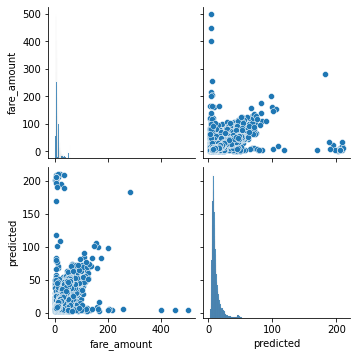

In [74]:
sns.pairplot(prediction_df[['fare_amount', 'predicted']])

array([[<AxesSubplot:title={'center':'fare_amount'}>,
        <AxesSubplot:title={'center':'predicted'}>]], dtype=object)

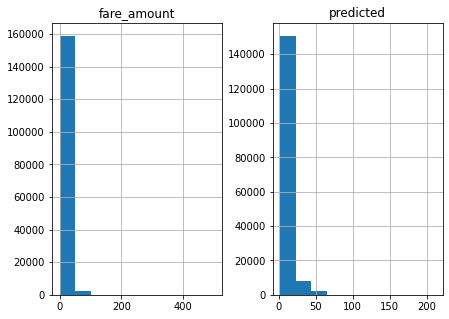

In [75]:
prediction_df.iloc[:,9:].hist(figsize = (7, 5))

# CONCLUSION & FINDINGS
### Five techniques were deployed to determine the Taxi fare_amount predictions. The purpose of trying the five models is to ascertain which of them would be able to give the best predictions as evaluated by the error standard and running time. These models are XGBoost, LightGBM, Ridge, RandomForestRegressor and Ordinary Least square(OLS)
### XGBOOST has RMSE of 9.15 and after changing some of the params it attained 4.95 which however was not better than LightGBM  whose RMSE of 0.2465. This shows that among these models LightGBM is the best model that should be utilized in New York City Taxi Fare amount prediction. However, R^2 for the RFR, Ridge, and OLS are 0.74, 0.6596 and 0.66 respectively.
### The observation is that the key parameters that would have been used for determining fare amount had not been employed in this scenario. . These key parameters are distance and time. 1% or 550000 was used in this study out of the 55million rows of dataset